# Time Series Analysis and Forecasting for Air Passengers Data

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)

from pylab import rcParams

#Size of plt.plot fig
rcParams['figure.figsize'] = 15, 5

df = pd.read_csv('AirPassengers.csv',parse_dates = True, index_col = 'Month')

In [2]:
#df = pd.read_csv('AirPassengers.csv')
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [4]:
ts = df['#Passengers']
ts

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, Length: 144, dtype: int64

In [5]:
ts['1949-01-01']
ts[datetime(1949,1,1)]

112

In [6]:
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [7]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

**********************
# **How to Check Stationarity of a Time Series?**

#### **Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:**

* Constant mean
* Constant variance
* An autocovariance that does not depend on time.
********************

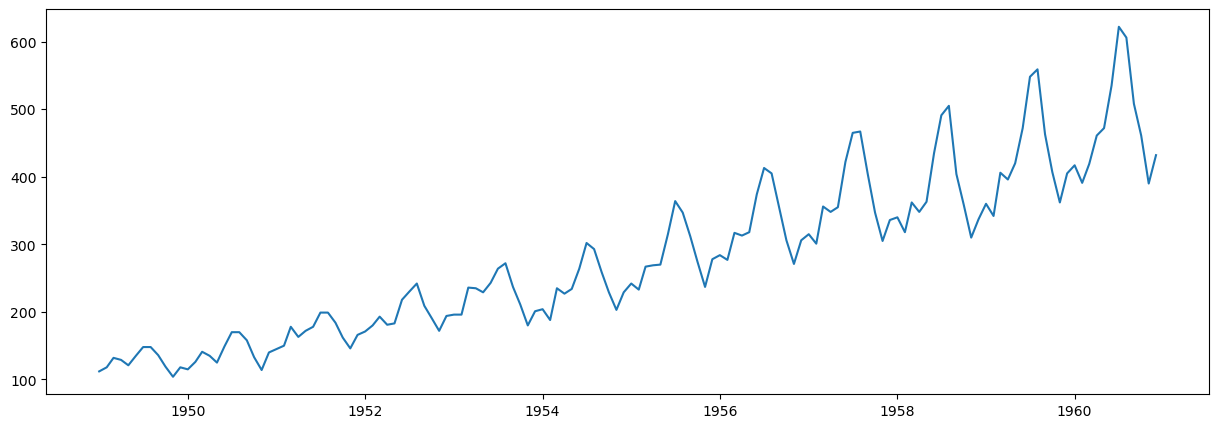

In [8]:
plt.plot(ts)

# **More formally, we can check stationarity using the following:**
*****
* **Plotting Rolling Statistics:** We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
* **Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 
*****

In [9]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

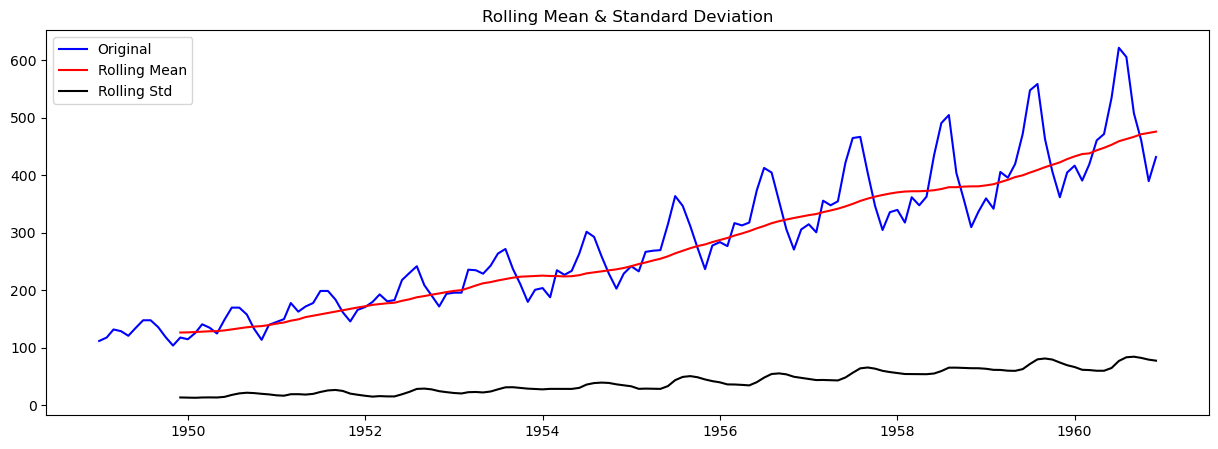

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
test_stationarity(ts)

# Make  Time Series Stationary
***
**Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:**
Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

# Estimating & Eliminating Trend

One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a  **log, square root, cube root, etc**. Lets take a log transform here for simplicity:


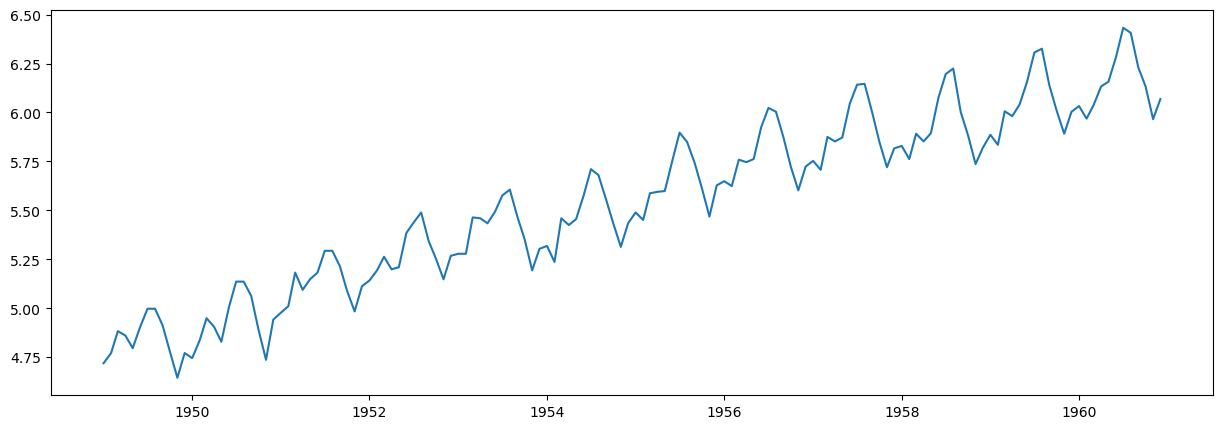

In [11]:
ts_log = np.log(ts)
plt.plot(ts_log)

In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

* **Aggregation –** taking average for a time period like monthly/weekly averages
* **Smoothing –** taking rolling averages
* **Polynomial Fitting –** fit a regression model

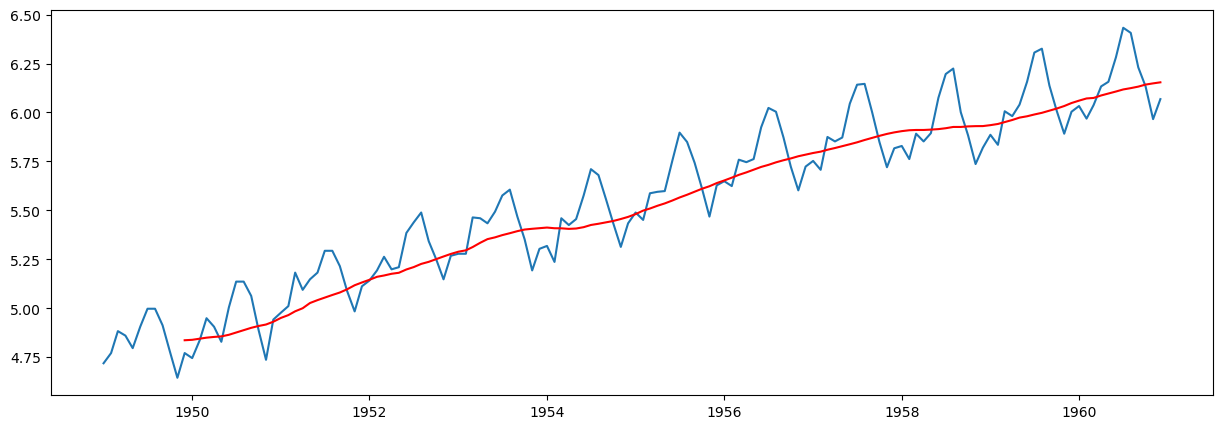

In [12]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:

In [13]:
ts_moving_avg_diff = ts_log - moving_avg
ts_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

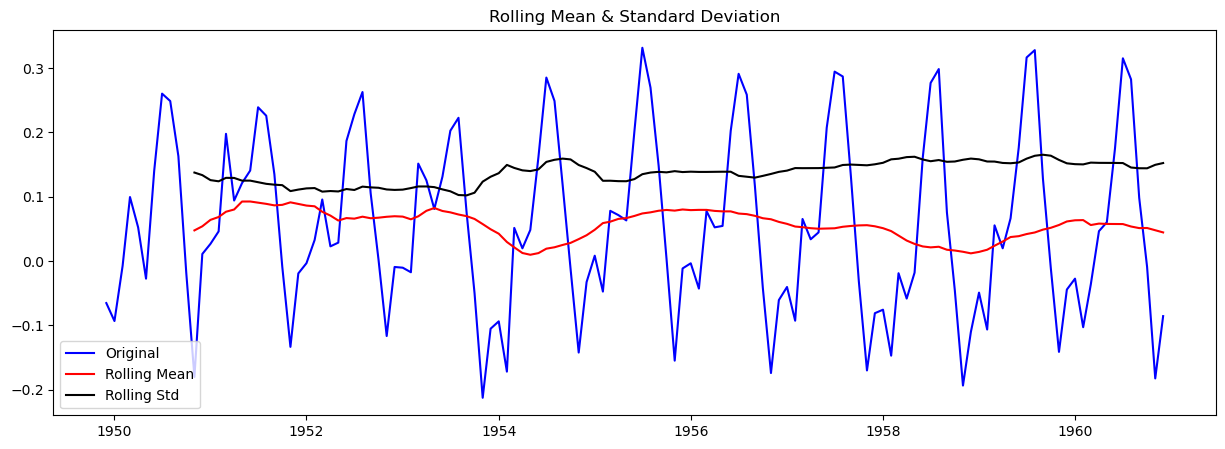

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [14]:
ts_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_moving_avg_diff)

### **Exponentially weighted moving average**

Note that here the parameter ‘halflife’ is used to define the amount of exponential decay. This is just an assumption here and would depend largely on the business domain. Other parameters like span and center of mass can also be used to define decay which are discussed in the link shared above. Now, let’s remove this from series and check stationarity:

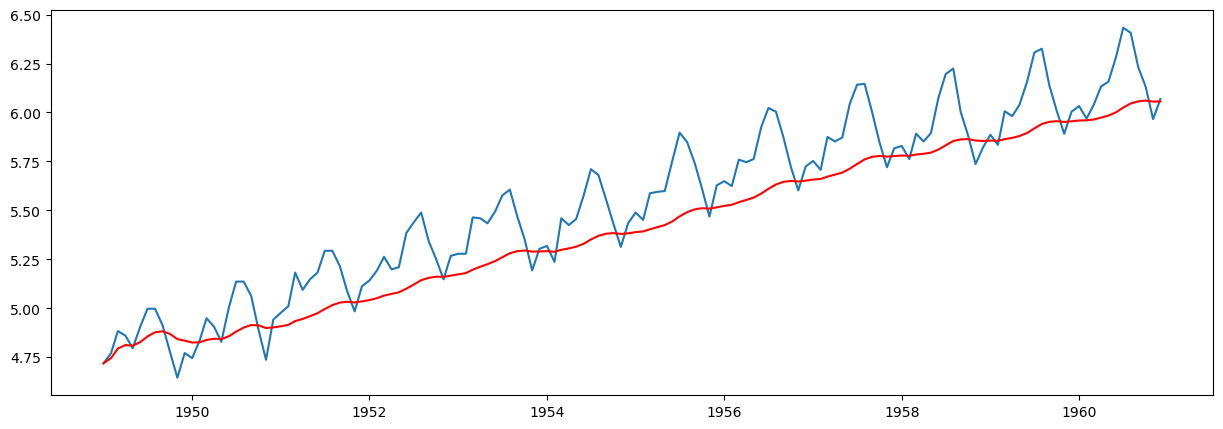

In [15]:
expweighted_mavg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(expweighted_mavg, color='red')

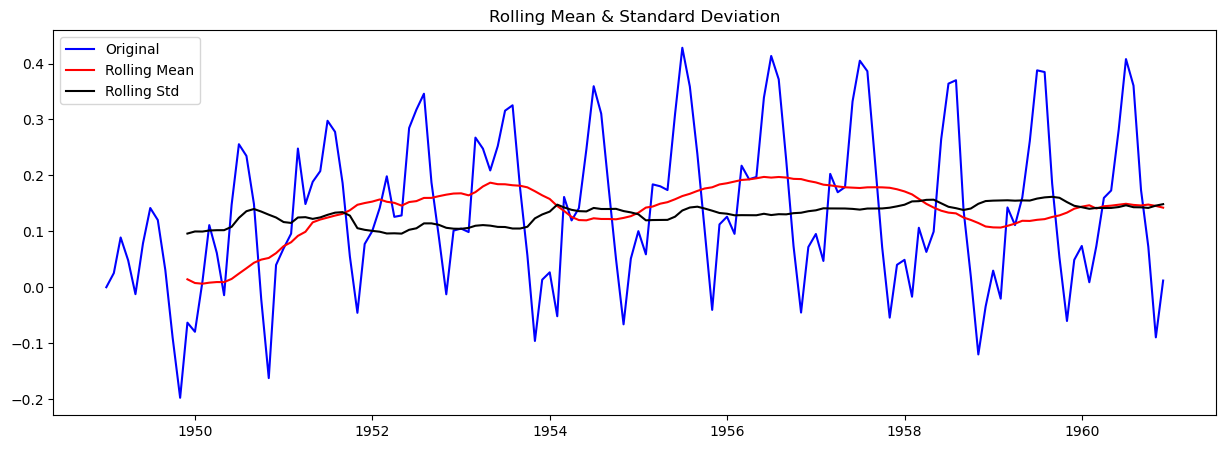

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [16]:
ts_log_ewma_diff = ts_log - expweighted_mavg
test_stationarity(ts_log_ewma_diff)

# Eliminating Trend and Seasonality


The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

 **Differencing** – taking the differece with a particular time lag
 
 **Decomposition** – modeling both trend and seasonality and removing them from the model.


#### **Differencing**

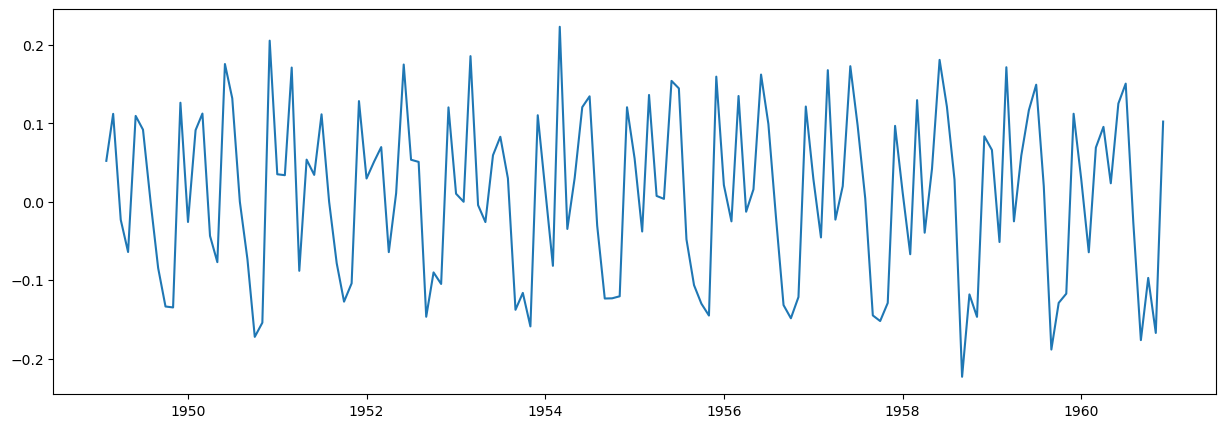

In [17]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

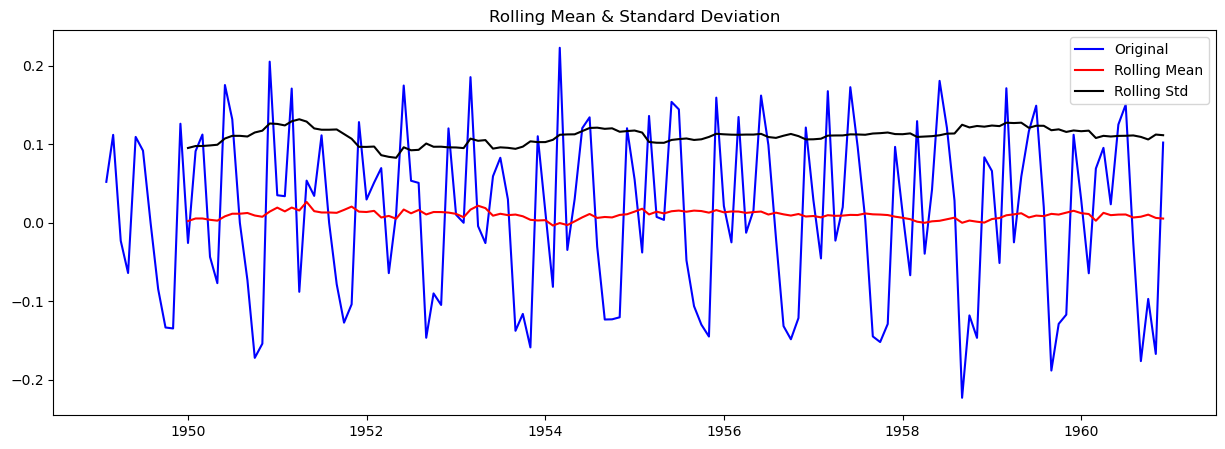

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [18]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

#### **Decomposing**

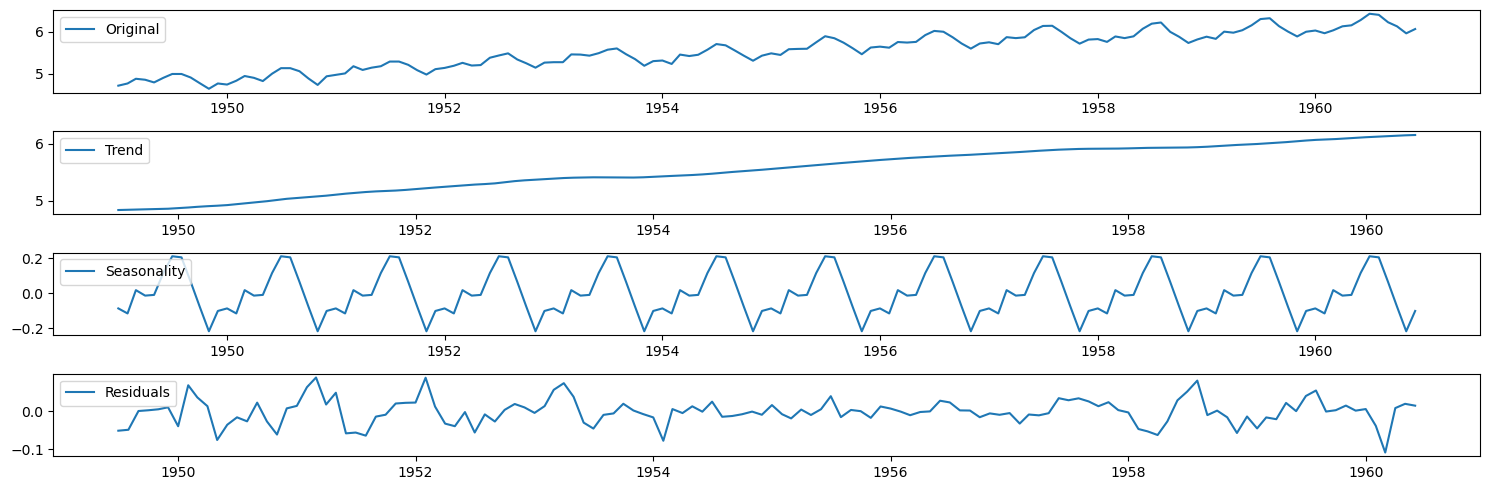

In [19]:
decomposing = seasonal_decompose(ts_log)

trend = decomposing.trend
seasonal = decomposing.seasonal
residual = decomposing.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

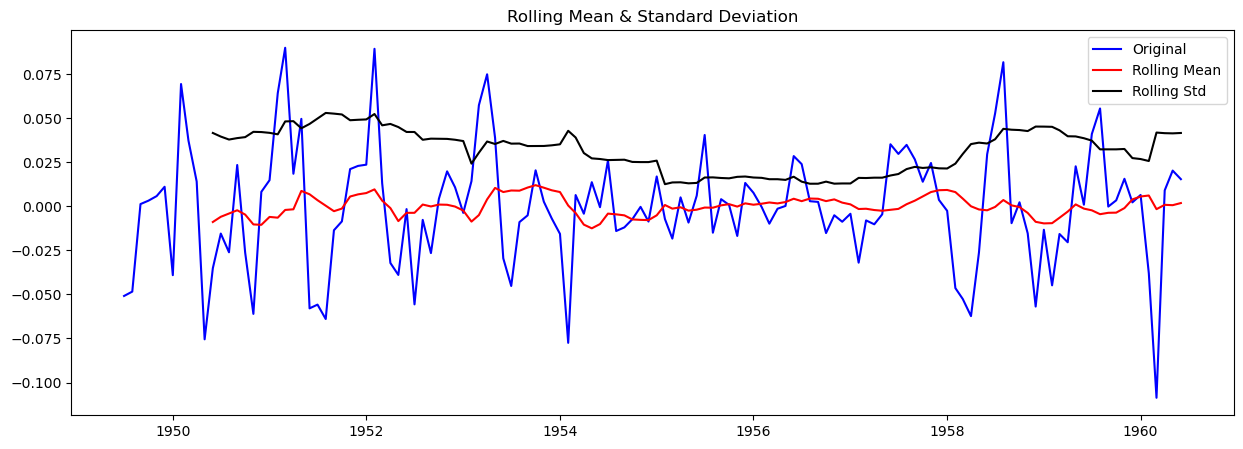

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [20]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [ ]:
# finding p,d,q we are using Auto ARIMA

In [27]:
from pmdarima.arima import auto_arima

In [28]:
model = auto_arima(ts_log_decompose, start_p=1, start_q=1,test='adf',max_p=5, max_q=5,m=1,          
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-491.950, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-498.930, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-500.789, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-493.925, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-527.109, Time=0.50 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-512.942, Time=0.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-526.998, Time=0.70 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-528.355, Time=0.60 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-524.504, Time=0.57 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-528.625, Time=0.68 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-526.689, Time=0.80 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=-528.092, Time=0.86 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-

# Build ARIMA Model

In [29]:
model = sm.tsa.arima.ARIMA(ts_log_diff, order=(0, 1, 5))
results = model.fit()

C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

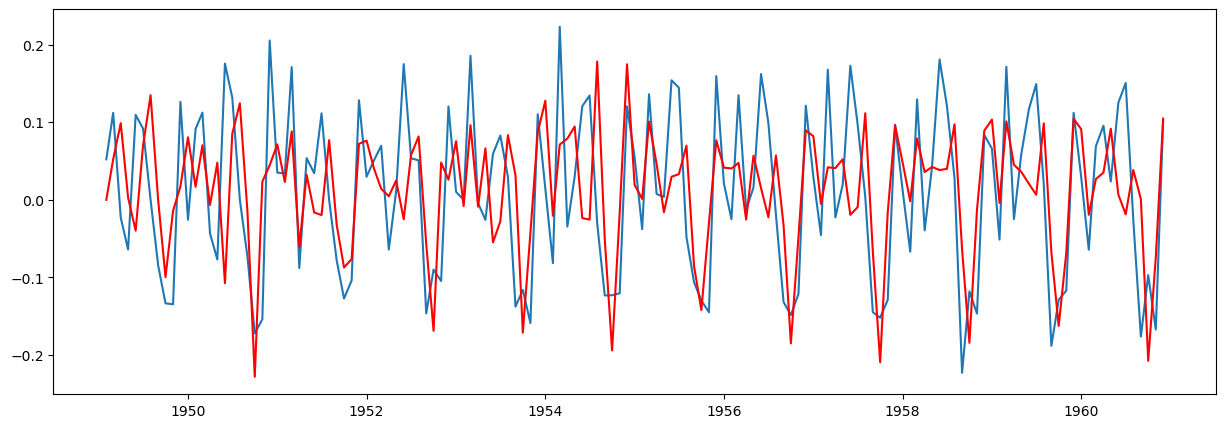

In [34]:
plt.plot(ts_log_diff)
plt.plot(results.fittedvalues, color='red')

# Model Evaluation

In [42]:
from sklearn.metrics import mean_squared_error
error=np.sqrt(mean_squared_error(ts_log_diff,results.fittedvalues))
error

0.09278036898977059